# Titanic: Machine Learning from Disaster
https://www.kaggle.com/c/titanic/leaderboard#score

  Predict survival on the Titanic and get familiar with ML basics
  ## Автор исследования: Янгузов Георгий

**План исследования**

 1. Описание набора данных и признаков
 2. Первичный анализ признаков
 3. Первичный визуальный анализ признаков
 4. Закономерности, "инсайты", особенности данных
 5. Предобработка данных
 6. Создание новых признаков и описание этого процесса
 7. Кросс-валидация, подбор параметров
 8. Построение кривых валидации и обучения 
 9. Прогноз для тестовой или отложенной выборки
 10. Оценка модели с описанием выбранной метрики
 11. Выводы

##  1. Описание набора данных и признаков Data Description
Overview
The data has been split into two groups:
* training set (train.csv)
* test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable - Definition - Key
* survival0 = No, 1 = Yes
* pclass - Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
* sex - Sex
* Age - Age in years
* sibsp # of siblings / spouses aboard the Titanic
* parch # of parents / children aboard the Titanic
* ticket - Ticket number
* fare - Passenger fare
* cabin - Cabin number
* embarked - Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes
pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


## 2. Первичный анализ данных

In [1]:
# Подключение библиотек
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'svg' 

In [2]:
# **Считываем обучающую и тестовую выборки.**
train_df = pd.read_csv("data/titanic_train.csv") 
test_df = pd.read_csv("data/titanic_test.csv") 

In [3]:
# Посмотрим информацию о таблице
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


В данных имеются пропуски в следующих признаках: <br>
*    Age          714 non-null    float64 <br>
*   Cabin        204 non-null    object  <br>

In [4]:
# Преобразуем категориальные прзнаки к соответствующему типу
# train_df[['Pclass', 'SibSp', 'Parch']]=train_df[['Pclass', 'SibSp', 'Parch']].astype('category')

In [5]:
# Посмотрим несколько строк таблицы
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Первый столбец PassengerId не несет в себе никакой информации, 
# сделаем столбец PassengerId индеком
train_df.set_index('PassengerId', inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
# Данные описательной статистики количественных признаков
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# доля выживших
str(round(train_df['Survived'].mean()*100, 2))+' %'

'38.38 %'

In [9]:
# Данные описательной статистики категориальных признаков
train_df.describe(include=['object', 'category'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Larsson, Mr. Bengt Edvin",male,CA. 2343,G6,S
freq,1,577,7,4,644


Из 891 пассажиров тренировочных данных 577 мужчин

In [10]:
# Рассмотрим средние значения количественных признаков в разрезе типа билета (класс) 
pd.pivot_table(train_df, index=['Pclass'])

,Age,Fare,Parch,SibSp,Survived
Pclass,,,,,
1,38.233441,84.154687,0.356481,0.416667,0.629630
2,29.877630,20.662183,0.380435,0.402174,0.472826
3,25.140620,13.675550,0.393075,0.615071,0.242363


Видим, что:
* Чем выше класс билета, тем старше в среднем пассажиры. <br>
* Так же чем выше класс билета, тем больше процент выживших. 

In [11]:
# Средние значения в срезе по полу
pd.pivot_table(train_df, index=['Sex'])

,Age,Fare,Parch,Pclass,SibSp,Survived
Sex,,,,,,
female,27.915709,44.479818,0.649682,2.159236,0.694268,0.742038
male,30.726645,25.523893,0.235702,2.389948,0.429809,0.188908


Среди женщин значительно больше процент выживших. 

In [12]:
# Средние значения в срезе по классу билета и по полу
pd.pivot_table(train_df, index=['Pclass', 'Sex'])

Age        Fare     Parch     SibSp  Survived
Pclass Sex                                                        
1      female  34.611765  106.125798  0.457447  0.553191  0.968085
       male    41.281386   67.226127  0.278689  0.311475  0.368852
2      female  28.722973   21.970121  0.605263  0.486842  0.921053
       male    30.740707   19.741782  0.222222  0.342593  0.157407
3      female  21.750000   16.118810  0.798611  0.895833  0.500000
       male    26.507589   12.661633  0.224784  0.498559  0.135447

In [13]:
# Вычислим попарную корреляцию столбцов.
train_df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Средняя корреляция между признаками Pclass и Fare (-0.549500) легко объяснима. 

Интереснее слабая корреляция между признаками SibSp и Parch (0.414838)  - можно предположить, некоторая часть из тех кто путешестововал семьей, были в большом составе, т.е. brother, sister, stepbrother, stepsister, husband, wife, mother, father, daughter, son, stepdaughter, stepson.

## 3. Первичный визуальный анализ данных
Посмотрим как связаны между собой различные признаки.

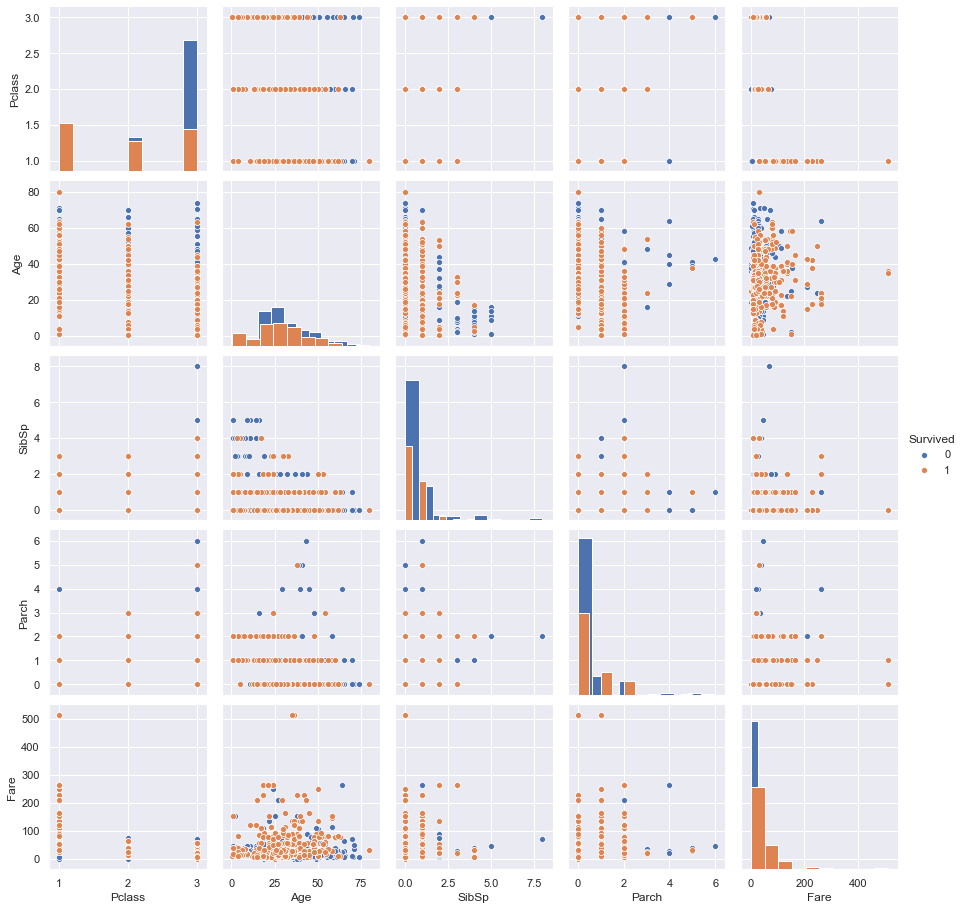

In [14]:
%config InlineBackend.figure_format = 'png' 
sns.pairplot(train_df, diag_kind='hist', hue='Survived');

Рассмотрим ближе интересующие нас диаграммы

Посмотрим распределения количественных признаков: Age и Fare

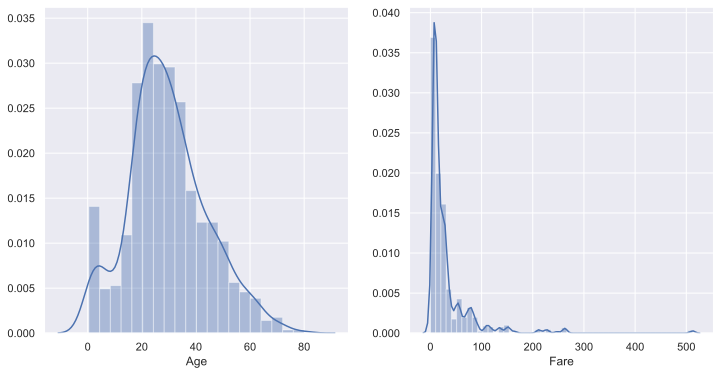

In [15]:
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.distplot(train_df[['Age']], label="Survived", ax=axes[0])
sns.distplot(train_df[['Fare']], label="Survived", ax=axes[1])
axes[0].set_xlabel('Age')
axes[1].set_xlabel('Fare');

Построим те же признаки (Age и Fare) в разрезе survival

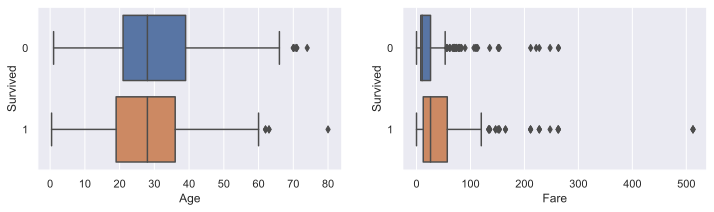

In [16]:
fig, axes = plt.subplots( ncols=2, figsize=(12, 3))
sns.boxplot(y='Survived', x='Age', orient="h", data=train_df, ax=axes[0])
sns.boxplot(y='Survived', x='Fare', orient="h", data=train_df, ax=axes[1])
axes[0].set_ylabel('Survived')
axes[0].set_xlabel('Age')
axes[1].set_ylabel('Survived')
axes[1].set_xlabel('Fare');

* В среднем выжившие пассажиры были моложе. 
* В среднем погибшие пассажиры купили более дешевые билеты. 

Теперь посмотрим на категориальные и порядновые признаки. Посторим стобчатые диаграммы для них.

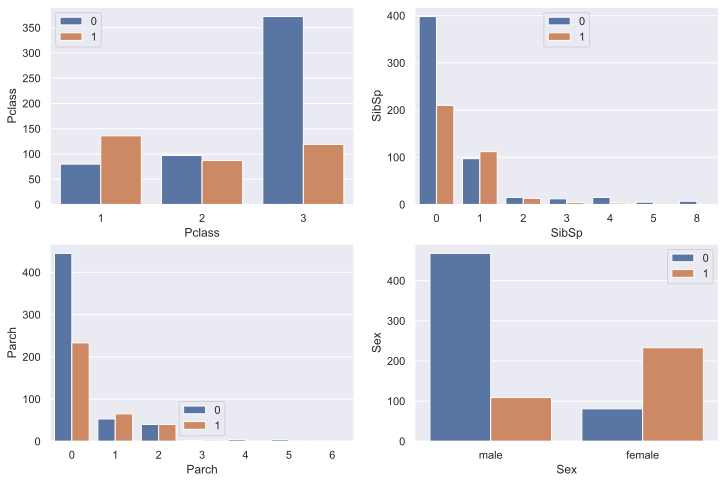

In [17]:
f=list(train_df.select_dtypes('int64').columns)
f.append('Sex')
f.remove('Survived')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for idx, feat in  enumerate(f):
    sns.countplot(x=feat,  hue="Survived", data=train_df, ax=axes[int(idx / 2), idx % 2]);
    axes[int(idx / 2), idx % 2].legend()
    axes[int(idx / 2), idx % 2].set_ylabel(feat);

На диаграммах видно, что в группах пассажиров перечисленных ниже большая часть погибла:
* пассажиры 3-го класса 
* пассажиры путешествывашие без семьи
* мужчины

Построим еще несколько диаграмм:

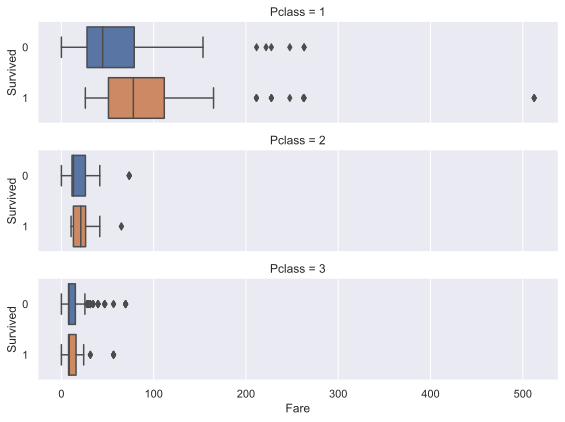

In [18]:
# Распределение стоимости билета в срезе класса билета
sns.catplot(x="Fare", y="Survived", row="Pclass", kind="box", 
            orient="h", height=2, aspect=4, data=train_df);

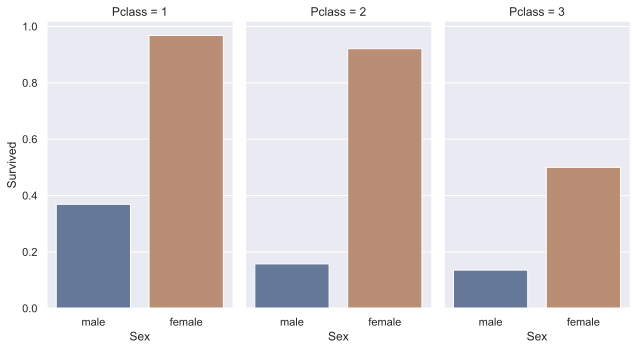

In [19]:
sns.catplot(x="Sex", y="Survived", col="Pclass",
                data=train_df, saturation=.5,
                kind="bar", ci=None, aspect=.6);

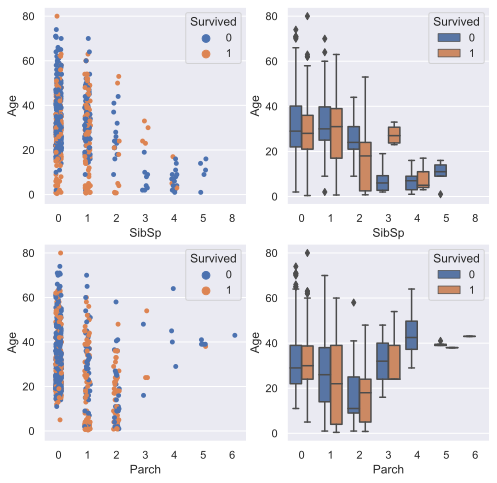

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
sns.stripplot(x="SibSp", y="Age", hue="Survived", data=train_df, ax=axes[0, 0])
sns.boxplot(x="SibSp", y="Age",  hue="Survived", data=train_df, ax=axes[0, 1])
sns.stripplot(x="Parch", y="Age", hue="Survived", data=train_df, ax=axes[1, 0])
sns.boxplot(x="Parch", y="Age", hue="Survived", data=train_df, ax=axes[1, 1]);

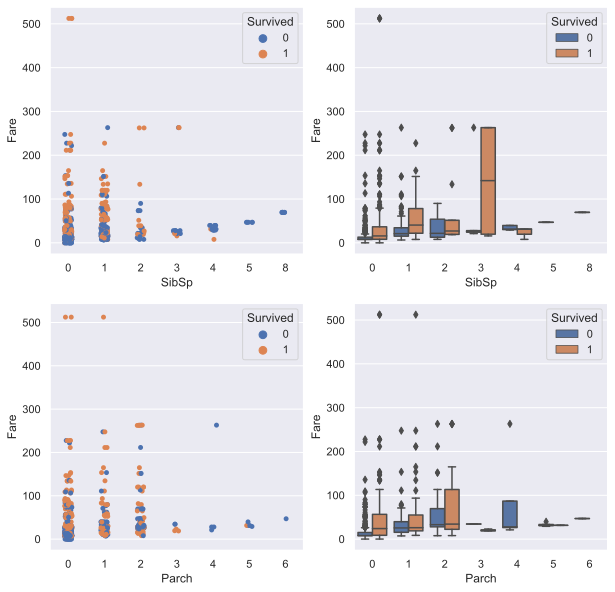

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.stripplot(x="SibSp", y="Fare", hue="Survived", data=train_df, ax=axes[0, 0])
sns.boxplot(x="SibSp", y="Fare",  hue="Survived", data=train_df, ax=axes[0, 1])
sns.stripplot(x="Parch", y="Fare", hue="Survived", data=train_df, ax=axes[1, 0])
sns.boxplot(x="Parch", y="Fare", hue="Survived", data=train_df, ax=axes[1, 1]);

## 4. Закономерности, "инсайты", особенности данных

**Итоги анализа тренировочных данных:**

Из 891 пассажиров 38.38 % выжевших

Чем выше класс билета, тем старше средний возраст пассажиров и больше процент выживших.

Среди женщин (314 из 891 пассажиров) значительно больше процент выживших. 

Есть слабая корреляция между признаками SibSp и Parch (0.414838) - можно предположить, что часть из тех пассажирове которые путешестововали семьей, были в большом составе.

В среднем выжившие пассажиры были моложе.

В среднем погибшие пассажиры купили более дешевые билеты.

Больше всего погибших в следюущих группах:
* пассажиры 3-го класса
* пассажиры путешествывашие без семьи
* мужчины


## 5. Предобработка данных

Заменм пропуски в данных медианными значениями

In [22]:
# **Заполним пропуски медианными значениями.**
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna('S', inplace=True)

test_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

## 6. Создание новых признаков и описание этого процесса
В описании данных на kagle.com есть сслыка https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/ на пример извлечения новых признаков из наших данных, грех ею не воспользоваться.

In [23]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:      
        if str(big_string).find(substring) != -1:
#             import pdb;pdb.set_trace()
            return substring
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

train_df['Title']=train_df['Name'].map(lambda x: substrings_in_string(x, title_list))
# train_df.info()

In [24]:
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train_df['Title']=train_df.apply(replace_titles, axis=1)

In [25]:
#Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_df['Deck']=train_df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [26]:
#Creating new family_size column
train_df['Family_Size']=train_df['SibSp']+train_df['Parch']

In [27]:
# This is an interaction term, since age and class are both numbers we can just multiply them.
train_df['Age*Class']=train_df['Age']*train_df['Pclass']
# Fare per Person
# Here we divide the fare by the number of family members traveling together, 
# I’m not exactly sure what this represents, but it’s easy enough to add in.
train_df['Fare_Per_Person']=train_df['Fare']/(train_df['Family_Size']+1)

In [28]:
# А это уже моя выдумка: Подсчет количества пассажиров в билете.
ticket=train_df[['Name','Ticket']].groupby('Ticket').count()
train_df=pd.merge(train_df, ticket, left_on='Ticket', right_index=True, how='left', sort=False)
train_df=train_df.rename(columns={"Name_y": "Count_Ticket", 'Name_x':'Name'})

In [29]:
# Извлечем теже признаки в тестовом наборе данных
test_df['Title']=test_df['Name'].map(lambda x: substrings_in_string(x, title_list))
test_df['Title']=test_df.apply(replace_titles, axis=1)

test_df['Deck']=test_df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

test_df['Family_Size']=test_df['SibSp']+test_df['Parch']

test_df['Age*Class']=test_df['Age']*test_df['Pclass']

test_df['Fare_Per_Person']=test_df['Fare']/(test_df['Family_Size']+1)

tticket=test_df[['Name','Ticket']].groupby('Ticket').count()
test_df=pd.merge(test_df, tticket, left_on='Ticket', right_index=True, how='left', sort=False)
test_df=test_df.rename(columns={"Name_y": "Count_Ticket", 'Name_x':'Name'})

In [30]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,Age*Class,Fare_Per_Person,Count_Ticket
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,1,66.0,3.62500,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1,38.0,35.64165,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,0,78.0,7.92500,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1,35.0,26.55000,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,0,105.0,8.05000,1


In [31]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,Age*Class,Fare_Per_Person,Count_Ticket
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,NaN,0,103.5,7.829200,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,NaN,1,141.0,3.500000,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,NaN,0,124.0,9.687500,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,NaN,0,81.0,8.662500,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,NaN,2,66.0,4.095833,1


In [32]:
y = train_df['Survived']

# **Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**
train_df = pd.concat([train_df, 
                      pd.get_dummies(train_df['Pclass'], prefix="PClass"),
                      pd.get_dummies(train_df['Sex'], prefix="Sex"),
                      pd.get_dummies(train_df['Embarked'], prefix="Embarked"),
                      pd.get_dummies(train_df['Deck'], prefix="Deck"),
                      pd.get_dummies(train_df['Title'], prefix="Title")],                     
                     axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Pclass'], prefix="PClass"),
                     pd.get_dummies(test_df['Sex'], prefix="Sex"),
                     pd.get_dummies(test_df['Title'], prefix="Title"),
                     pd.get_dummies(test_df['Deck'], prefix="Deck"),
                     pd.get_dummies(test_df['Embarked'], prefix="Embarked")],
                    axis=1)

train_df.drop(['Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Deck', 'Title'], axis=1, inplace=True)
test_df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'Deck', 'Title'], axis=1, inplace=True)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              891 non-null    float64
 1   SibSp            891 non-null    int64  
 2   Parch            891 non-null    int64  
 3   Fare             891 non-null    float64
 4   Family_Size      891 non-null    int64  
 5   Age*Class        891 non-null    float64
 6   Fare_Per_Person  891 non-null    float64
 7   Count_Ticket     891 non-null    int64  
 8   PClass_1         891 non-null    uint8  
 9   PClass_2         891 non-null    uint8  
 10  PClass_3         891 non-null    uint8  
 11  Sex_female       891 non-null    uint8  
 12  Sex_male         891 non-null    uint8  
 13  Embarked_C       891 non-null    uint8  
 14  Embarked_Q       891 non-null    uint8  
 15  Embarked_S       891 non-null    uint8  
 16  Deck_A           891 non-null    uint8  
 17  Deck_B          

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              418 non-null    float64
 1   SibSp            418 non-null    int64  
 2   Parch            418 non-null    int64  
 3   Fare             418 non-null    float64
 4   Family_Size      418 non-null    int64  
 5   Age*Class        418 non-null    float64
 6   Fare_Per_Person  418 non-null    float64
 7   Count_Ticket     418 non-null    int64  
 8   PClass_1         418 non-null    uint8  
 9   PClass_2         418 non-null    uint8  
 10  PClass_3         418 non-null    uint8  
 11  Sex_female       418 non-null    uint8  
 12  Sex_male         418 non-null    uint8  
 13  Title_Master     418 non-null    uint8  
 14  Title_Miss       418 non-null    uint8  
 15  Title_Mr         418 non-null    uint8  
 16  Title_Mrs        418 non-null    uint8  
 17  Deck_A          

In [35]:
train_df.drop(['Deck_T'], axis=1, inplace=True)

In [36]:
train_df.head()

,Age,SibSp,Parch,Fare,Family_Size,Age*Class,Fare_Per_Person,Count_Ticket,PClass_1,PClass_2,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,1,66.0,3.62500,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38.0,1,0,71.2833,1,38.0,35.64165,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,26.0,0,0,7.9250,0,78.0,7.92500,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,1,0,53.1000,1,35.0,26.55000,2,1,0,...,0,1,0,0,0,0,0,0,0,1
5,35.0,0,0,8.0500,0,105.0,8.05000,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
test_df.head()

,Age,SibSp,Parch,Fare,Family_Size,Age*Class,Fare_Per_Person,Count_Ticket,PClass_1,PClass_2,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,103.5,7.829200,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,1,0,7.0000,1,141.0,3.500000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,0,0,9.6875,0,124.0,9.687500,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,27.0,0,0,8.6625,0,81.0,8.662500,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,1,1,12.2875,2,66.0,4.095833,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## 7. Кросс-валидация, подбор параметров

In [39]:
# **Функция для формирования csv-файла посылки на Kaggle:**

def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [40]:
# Дерево решений с настройкой параметров 
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=17)

# tree params for grid search
tree_params = {'max_depth': list(range(1, 5)), 
               'min_samples_leaf': list(range(1, 5)),
              'max_features':[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tree_grid = GridSearchCV(clf_tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(train_df, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    6.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy', max_depth=2,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_

In [41]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 3, 'max_features': 0.9, 'min_samples_leaf': 1},
 0.8260184545853996)

In [43]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"');

<IPython.core.display.Javascript object>

In [45]:
y_test=tree_grid.predict(test_df)

write_to_submission_file(y_test, '%s.csv' %nb_name[:-6])
